# Load Dependencies

In [1]:
import xgboost as xgb
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
des=np.load('./data/des.npy')
ddg=np.load('./data/ddg.npy')

# Models

In [3]:
models = [BaggingRegressor(n_jobs=60),
          tree.DecisionTreeRegressor(),ExtraTreesRegressor(n_jobs=60),GradientBoostingRegressor(),
          KNeighborsRegressor(),KernelRidge(),
          LinearSVR(),RandomForestRegressor(n_jobs=60),
          linear_model.Ridge(alpha=.5),SVR(), xgb.XGBRegressor(n_jobs=60)]
model_names = ['BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB']
descs = [des]
desc_names = ['CD']

# Train

In [4]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
kfold = KFold(n_splits=10,shuffle=True)
performance_dict = {}
train_index=list(set(list(range(59))))
for desc,desc_name in zip(descs,desc_names): 
    desc=desc[train_index]
    ee_=ddg[train_index]
    for model,model_name in zip(models,model_names):
        all_r2 = []
        all_pearsr = []
        all_mae = []
        repeat_pred = []
        repeat_test = []
        for i in range(10):
            all_pred = []
            all_test = []
            for train_index_tep,test_index_tep in kfold.split(desc):
                train_x,test_x = desc[train_index_tep],desc[test_index_tep]
                train_y,test_y = ee_[train_index_tep],ee_[test_index_tep]
                model.fit(train_x,train_y)
                test_pred = model.predict(test_x)
                all_pred.append(test_pred)
                all_test.append(test_y)
            all_pred = np.concatenate(all_pred)
            all_test = np.concatenate(all_test)
            repeat_pred.append(all_pred)
            repeat_test.append(all_test)
            r2 = r2_score(all_test,all_pred)
            pearsr = pearsonr(all_test,all_pred)
            mae = mean_absolute_error(all_test,all_pred)
            all_r2.append(r2)
            all_pearsr.append(pearsr[0])
            all_mae.append(mae)
        performance_dict['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),np.mean(all_mae),np.mean(all_pearsr),
                                                            repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,np.mean(all_r2),np.mean(all_mae),np.mean(all_pearsr)))

Model:    BG, Descriptor:              CD: R2: 0.6168, MAE: 0.2145, Pearson R: 0.7912
Model:    DT, Descriptor:              CD: R2: 0.3387, MAE: 0.2679, Pearson R: 0.6649
Model:    ET, Descriptor:              CD: R2: 0.6147, MAE: 0.2076, Pearson R: 0.7897
Model:    GB, Descriptor:              CD: R2: 0.6642, MAE: 0.2118, Pearson R: 0.8190
Model:   KNR, Descriptor:              CD: R2: 0.6032, MAE: 0.2351, Pearson R: 0.7772
Model:   KRR, Descriptor:              CD: R2: 0.6946, MAE: 0.2051, Pearson R: 0.8342
Model:  LSVR, Descriptor:              CD: R2: 0.6919, MAE: 0.1960, Pearson R: 0.8413
Model:    RF, Descriptor:              CD: R2: 0.6554, MAE: 0.2033, Pearson R: 0.8118
Model: Ridge, Descriptor:              CD: R2: 0.6909, MAE: 0.2089, Pearson R: 0.8326
Model:   SVR, Descriptor:              CD: R2: 0.6647, MAE: 0.2217, Pearson R: 0.8215
Model:   XGB, Descriptor:              CD: R2: 0.5633, MAE: 0.2275, Pearson R: 0.7703


# Results

## Pearson R

<AxesSubplot:>

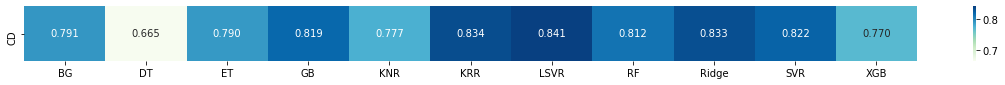

In [5]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][2]

fig = plt.figure(figsize=(20,1))
sns.heatmap(r2_map,annot=True,fmt='.3f',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')

## Best Results

Text(0.1, 1.6, 'MAE: 0.196')

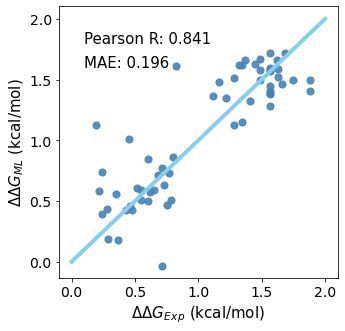

In [7]:
model = 'LSVR-CD'
train_y = performance_dict[model][4]
train_p = performance_dict[model][3]


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
plt.xticks(np.arange(0, 2.1, step=0.5),fontsize=14)
plt.yticks(np.arange(0, 2.1, step=0.5),fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=15)
plt.plot([0,2],[0,2],c='skyblue',linewidth=4)
plt.scatter(np.array(train_y),np.array(train_p),c='steelblue',s=50, alpha=0.9)
plt.text(0.1,1.8,'Pearson R: %.3f'%performance_dict[model][2],fontsize=15)
plt.text(0.1,1.6,'MAE: %.3f'%mean_absolute_error(np.array(train_y),np.array(train_p)),fontsize=15)


In [8]:
np.save('./data/kt_performance_dict.npy',performance_dict)